In [1]:
#imports
import numpy as np
from scipy.optimize import curve_fit
from scipy.integrate import odeint
from scipy import integrate
import matplotlib.pyplot as plt
from lmfit import minimize, Parameters, Parameter, report_fit
from sklearn.metrics import r2_score
import random
from bayes_opt import BayesianOptimization

In [50]:
#function for getting rate graphs
def change_coord(data, init, timespan):
    yield_list_E = []
    yield_list_A1 = []
    yield_list_A2 = []
    yield_list_tE = []
    for i in range(len(data[0])):
        yield_list_E.append((data[0][i])/init[0])
        yield_list_A1.append((data[1][i])/init[0])
        yield_list_A2.append((data[2][i])/init[0])
        yield_list_tE.append((data[3][i])/init[0])
    yield_lists = [yield_list_E,yield_list_A1,yield_list_A2,yield_list_tE]

    rate_list_E = []
    rate_list_A1 = []
    rate_list_A2 = []
    rate_list_tE = []
    for i in range(len(data[0])-1):
        rate_list_E.append((data[0][i+1]-data[0][i])/(timespan[i+1]-timespan[i]))
        rate_list_A1.append((data[1][i+1]-data[1][i])/(timespan[i+1]-timespan[i]))
        rate_list_A2.append((data[2][i+1]-data[2][i])/(timespan[i+1]-timespan[i]))
        rate_list_tE.append((data[3][i+1]-data[3][i])/(timespan[i+1]-timespan[i]))
    rate_lists = [rate_list_E,rate_list_A1,rate_list_A2,rate_list_tE]

    return yield_lists, rate_lists

In [74]:
#needed parameters
T = 393
P = 50
KH= 1282
CH2 = P/KH
KlaH2 = 4.5e-2
R= 8.314
timespan = [0, 1.46, 3.46, 5.46, 7.46, 9.46, 11.46, 13.46, 15.46, 19.46, 23.46, 27.46, 31.46, 40.46, 50.46, 60.46, 90.46, 120.46, 150.46, 180.46, 240.46, 300.46, 360.46, 440.46, 530.46, 620.46, 810.46, 900.46, 955, 1246]
trim_1 = 30
trim_2 = 30
trim_3 = 30
time_1 = timespan[-1]
time_2 = timespan[-1]
time_3 = timespan[-1]
init_1 = [1,0,0,0,1,0,0,0]
init_2 = [4,0,0,0,2,0,0,0]
init_3 = [8,0,0,0,1.5,0,0,0]

In [75]:
# base rate constants
k1 = 0.01209668296564242
k2f = 0.01517495478255645
k2b = 0.0042608145032644508
k3 = 0.0897487647678990227
k4 = 0.032891811706016034
k5 = 0.012690318715024702

In [76]:
#fyunction for getting activation energy from rate constants and pre factors
def get_Eact(A, ktrue):
    T=363
    pre = (np.log(ktrue/A))*R*T
    return pre

In [77]:
#making the kinetic parameters
A1 = 4
A2f = 1.6
A2b = 1
A3 = 5
A4 = 2
A5 = 40
A6 = 4
E1 = get_Eact(A1,k1)
E2f = get_Eact(A2f,k2f)
E2b = get_Eact(A2b,k2b)
E3 = get_Eact(A3,k3)
E4 = get_Eact(A4,k4)
E5 = get_Eact(A5,k5)
print(E1,E2f,E2b,E3,E4,E5)

-17507.670790808534 -14058.099832950747 -16473.035876675956 -12132.827638991428 -12396.90042987989 -24312.245320450187


In [78]:
#getting the rate constants at the current temperature
k1 = A1*np.exp(E1/(R*T))
k2f = A2f*np.exp(E2f/(R*T))
k2b = A2b*np.exp(E2b/(R*T))
k3 = A3*np.exp(E3/(R*T))
k4 = A4*np.exp(E4/(R*T))
k5 = A5*np.exp(E5/(R*T))
print(k1,k2f,k2b,k3,k4,k5)

0.01883590224472234 0.021654807126415244 0.006463196927233503 0.12198500798488923 0.0450056034587339 0.02347146917101018


In [79]:
#function for getting noise
def get_noise():
    static_noise = np.random.normal(0,0.01,30)
    variable_noise = np.random.normal(0,0.05,30)
    return static_noise, variable_noise

In [80]:
#system of ODE's
def diff(x, init):
    CE, CA1, CA2, CtE,Cprecat, Ccat, Ccatdead, H2uptake = init
    dEdt = -k1*CE*Cprecat - k2f*CE*CA1 + k2b*CtE*CA2
    dA1dt = k1*CE*Cprecat - k2f*CE*CA1 + k2b*CtE*CA2 + 2*k3*CtE*Cprecat
    dA2dt = k1*CE*Cprecat + k2f*CE*CA1 - k2b*CtE*CA2
    dtEdt = k2f*CE*CA1 - k2b*CtE*CA2 - k3*CtE*Cprecat
    dprecatdt = -k1*CE*Cprecat - k3*CtE*Cprecat + k4*Ccat*CH2 - k5*Cprecat
    dcatdt = k1*CE*Cprecat + k3*CtE*Cprecat - k4*Ccat*CH2
    dcatdeaddt = k5*Cprecat
    dH2uptakedt = k4*Ccat*CH2
    return dEdt, dA1dt, dA2dt, dtEdt, dprecatdt, dcatdt,dcatdeaddt, dH2uptakedt

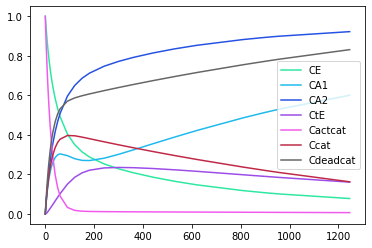

In [81]:
#plots made for different initial conditions
sol_1 = integrate.solve_ivp(diff, [0,time_1], init_1, t_eval = timespan)
plt.plot(sol_1.t,sol_1.y[0], label = 'CE',color = '#2DE8A0')
plt.plot(sol_1.t,sol_1.y[1], label = 'CA1', color = '#1EBAEE')
plt.plot(sol_1.t,sol_1.y[2], label = 'CA2', color = '#2652E3')
plt.plot(sol_1.t,sol_1.y[3], label = 'CtE', color = '#9C4CE8')
plt.plot(sol_1.t,sol_1.y[4], label = 'Cactcat', color = '#F05BEE')
plt.plot(sol_1.t,sol_1.y[5], label = 'Ccat',color = '#BF2947')
plt.plot(sol_1.t,sol_1.y[6], label = 'Cdeadcat',color = '#666666')
# plt.plot(sol_1.t, sol_1.y[0]*2 +sol_1.y[1] +sol_1.y[2] +sol_1.y[3]*2, label = 'total')
plt.legend()
# plt.savefig("MEP_figures/323_plot.png",dpi=300)

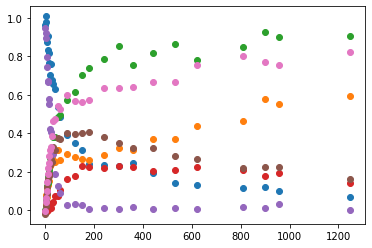

In [83]:
#block that adds noise to the data
noisy_data_list = []
i = 0
for res in range(len(sol_1.y)):
    static_noise,variable_noise = get_noise()
    noisy_data = sol_1.y[i] + static_noise + np.multiply(sol_1.y[i],variable_noise)
    noisy_data_list.append(noisy_data)
    i += 1
    
if trim_1 < len(timespan):
    for i in range(len(noisy_data_list)):
        noisy_data_list[i] = noisy_data_list[i][:trim_1-resolution]

plt.scatter(timespan, noisy_data_list[0], label = 'noisy CE')
plt.scatter(timespan, noisy_data_list[1], label = 'noisy CA1')
plt.scatter(timespan, noisy_data_list[2], label = 'noisy CA2')
plt.scatter(timespan, noisy_data_list[3], label = 'noisy CtE')
plt.scatter(timespan, noisy_data_list[4], label = 'noisy Cprecat')
plt.scatter(timespan, noisy_data_list[5], label = 'noisy Ccat')
plt.scatter(timespan, noisy_data_list[6], label = 'noisy Ccatdead')

In [84]:
#block that converts normal graphs to yield/rate graphs
yield_lists_1, rate_lists_1  = change_coord(noisy_data_list,init_1,timespan)

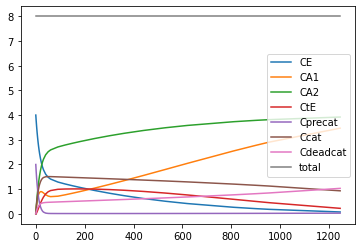

In [85]:
#solution for other initial condition
sol_2 = integrate.solve_ivp(diff, [0,time_2], init_2, t_eval = timespan)
plt.plot(sol_2.t,sol_2.y[0], label = 'CE')
plt.plot(sol_2.t,sol_2.y[1], label = 'CA1')
plt.plot(sol_2.t,sol_2.y[2], label = 'CA2')
plt.plot(sol_2.t,sol_2.y[3], label = 'CtE')
plt.plot(sol_2.t,sol_2.y[4], label = 'Cprecat')
plt.plot(sol_2.t,sol_2.y[5], label = 'Ccat')
plt.plot(sol_2.t,sol_2.y[6], label = 'Cdeadcat')
plt.plot(sol_2.t, sol_2.y[0]*2 +sol_2.y[1] +sol_2.y[2] +sol_2.y[3]*2, label = 'total')
plt.legend()

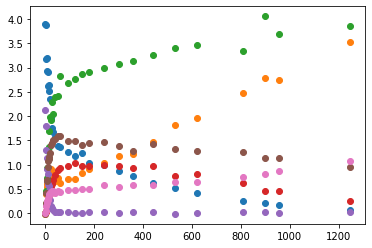

In [86]:
#add noise
noisy_data_list_2 = []
i = 0
for res in range(len(sol_2.y)):
    static_noise,variable_noise = get_noise()
    noisy_data = sol_2.y[i] + static_noise + np.multiply(sol_2.y[i],variable_noise)
    noisy_data_list_2.append(noisy_data)
    i += 1
    
if trim_2 < len(timespan):
    for i in range(len(noisy_data_list_2)):
        noisy_data_list_2[i] = noisy_data_list_2[i][:trim_2-resolution]
        
plt.scatter(timespan, noisy_data_list_2[0], label = 'noisy CE')
plt.scatter(timespan, noisy_data_list_2[1], label = 'noisy CA1')
plt.scatter(timespan, noisy_data_list_2[2], label = 'noisy CA2')
plt.scatter(timespan, noisy_data_list_2[3], label = 'noisy CtE')
plt.scatter(timespan, noisy_data_list_2[4], label = 'noisy Cprecat')
plt.scatter(timespan, noisy_data_list_2[5], label = 'noisy Ccat')
plt.scatter(timespan, noisy_data_list_2[6], label = 'noisy Ccatdead')

In [87]:
yield_lists_2, rate_lists_2  = change_coord(noisy_data_list_2,init_2,timespan)

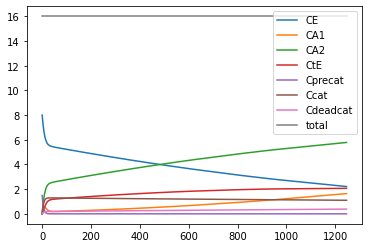

In [88]:
sol_3 = integrate.solve_ivp(diff, [0,time_3], init_3, t_eval = timespan)
plt.plot(sol_3.t,sol_3.y[0], label = 'CE')
plt.plot(sol_3.t,sol_3.y[1], label = 'CA1')
plt.plot(sol_3.t,sol_3.y[2], label = 'CA2')
plt.plot(sol_3.t,sol_3.y[3], label = 'CtE')
plt.plot(sol_3.t,sol_3.y[4], label = 'Cprecat')
plt.plot(sol_3.t,sol_3.y[5], label = 'Ccat')
plt.plot(sol_3.t,sol_3.y[6], label = 'Cdeadcat')
plt.plot(sol_3.t, sol_3.y[0]*2 +sol_3.y[1] +sol_3.y[2] +sol_3.y[3]*2, label = 'total')
plt.legend()

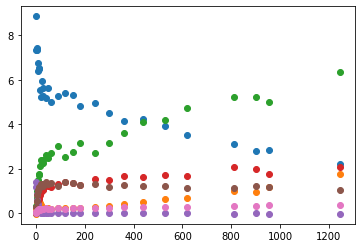

In [89]:
#add noise
noisy_data_list_3 = []
i = 0

for res in range(len(sol_3.y)):
    static_noise,variable_noise = get_noise()
    noisy_data = sol_3.y[i] + static_noise + np.multiply(sol_3.y[i],variable_noise)
    noisy_data_list_3.append(noisy_data)
    i += 1


if trim_3 < len(timespan):
    for i in range(len(noisy_data_list_3)):
        noisy_data_list_3[i] = noisy_data_list_3[i][:trim_3-resolution]
        


plt.scatter(timespan, noisy_data_list_3[0], label = 'noisy CE')
plt.scatter(timespan, noisy_data_list_3[1], label = 'noisy CA1')
plt.scatter(timespan, noisy_data_list_3[2], label = 'noisy CA2')
plt.scatter(timespan, noisy_data_list_3[3], label = 'noisy CtE')
plt.scatter(timespan, noisy_data_list_3[4], label = 'noisy Cprecat')
plt.scatter(timespan, noisy_data_list_3[5], label = 'noisy Ccat')
plt.scatter(timespan, noisy_data_list_3[6], label = 'noisy Ccatdead')

In [90]:
yield_lists_3, rate_lists_3  = change_coord(noisy_data_list_3,init_3,timespan)

In [91]:
#function for getting r2_score more easily
def get_r2(real,simul):
    return r2_score(real[0], simul[0]) + (r2_score(real[1], simul[1])) + (r2_score(real[2], simul[2])) + (r2_score(real[3], simul[3]))

In [92]:
#same differential, but now usable for different constants that the guessing algorithm is going to give it
def diff(x, init, constants):
    k1, k2f, k2b, k3, k4, k5= constants['k1'],constants['k2f'],constants['k2b'],constants['k3'],constants['k4'],constants['k5']
    CE, CA1, CA2, CtE,Cprecat, Ccat, Ccatdead, H2uptake = init
    dEdt = -k1*CE*Cprecat - k2f*CE*CA1 + k2b*CtE*CA2
    dA1dt = k1*CE*Cprecat - k2f*CE*CA1 + k2b*CtE*CA2 + 2*k3*CtE*Cprecat
    dA2dt = k1*CE*Cprecat + k2f*CE*CA1 - k2b*CtE*CA2
    dtEdt = k2f*CE*CA1 - k2b*CtE*CA2 - k3*CtE*Cprecat
    dprecatdt = -k1*CE*Cprecat - k3*CtE*Cprecat + k4*Ccat*CH2 - k5*Cprecat
    dcatdt = k1*CE*Cprecat + k3*CtE*Cprecat - k4*Ccat*CH2
    dcatdeaddt = k5*Cprecat
    dH2uptakedt = k4*Ccat*CH2
    return dEdt, dA1dt, dA2dt, dtEdt, dprecatdt, dcatdt,dcatdeaddt, dH2uptakedt

In [93]:
#test R squared comparison for random values    
ind = {'k1': k1, 'k2f': k2f, 'k2b': k2b, 'k3': k3, 'k4': k4, 'k5': k5}
best_1 = integrate.solve_ivp(diff, [0,time_1], init_1, args = (ind,), t_eval = timespan)
best_2 = integrate.solve_ivp(diff, [0,time_2], init_2, args = (ind,), t_eval = timespan)
best_3 = integrate.solve_ivp(diff, [0,time_3], init_3, args = (ind,), t_eval = timespan)
changed_yields_1, changed_rates_1 = change_coord(best_1.y,init_1,timespan)
changed_yields_2, changed_rates_2 = change_coord(best_2.y,init_2,timespan)
changed_yields_3, changed_rates_3 = change_coord(best_3.y,init_3,timespan)
print(get_r2(noisy_data_list, best_1.y)
      +(get_r2(noisy_data_list_2,best_2.y))
      +(get_r2(noisy_data_list_3,best_3.y)))
print(get_r2(yield_lists_1,changed_yields_1)
      +get_r2(yield_lists_2,changed_yields_2)
      +get_r2(yield_lists_3,changed_yields_3))
print(get_r2(rate_lists_1,changed_rates_1)
      +get_r2(rate_lists_2,changed_rates_2)
      +get_r2(rate_lists_3,changed_rates_3))

11.827413797696147
11.827413797696147
6.613726391383943


5.851619337888273
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 417
    # data points      = 6
    # variables        = 6
    chi-square         = 11375.7726
    reduced chi-square = 11375.7726
    Akaike info crit   = 57.2848901
    Bayesian info crit = 56.0354470
##  Warning: uncertainties could not be estimated:
[[Variables]]
    k1:   0.01754452 +/-        nan (nan%) (init = 0.01)
    k2f:  0.01725260 +/- 2.6987e+08 (1564233157750.31%) (init = 0.01)
    k2b:  0.00519109 +/- 2.5718e+08 (4954285274422.50%) (init = 0.01)
    k3:   0.01440375 +/- 0.00000000 (0.00%) (init = 0.01)
    k4:   0.04429291 +/-        nan (nan%) (init = 0.01)
    k5:   0.01018776 +/-        nan (nan%) (init = 0.01)
[[Correlations]] (unreported correlations are < 0.100)
    C(k2b, k3)  =  inf
    C(k2f, k3)  =  inf
    C(k2f, k2b) =  0.516


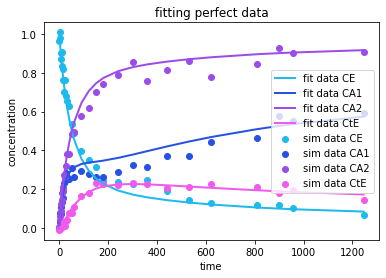

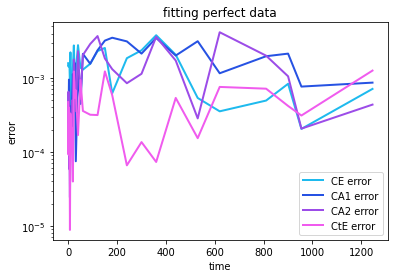

In [96]:
#main workhorse of the script, guesses constants, and minimizes the residual of the outcome
def residual(paras, timespan):

    """
    compute the residual between actual data and fitted data
    """
    subject = {'k1': paras['k1'].value, 'k2f': paras['k2f'].value, 'k2b': paras['k2b'].value, 'k3': paras['k3'].value, 'k4': paras['k4'].value, 'k5': paras['k5'].value}
    sol_1 = integrate.solve_ivp(diff, [0,time_1], init_1, args = (subject,), t_eval = timespan)
    sol_2 = integrate.solve_ivp(diff, [0,time_2], init_2, args = (subject,), t_eval = timespan)
    sol_3 = integrate.solve_ivp(diff, [0,time_3], init_3, args = (subject,), t_eval = timespan)
    changed_yields_1, changed_rates_1 = change_coord(sol_1.y,init_1,timespan)
    changed_yields_2, changed_rates_2 = change_coord(sol_2.y,init_2,timespan)
    changed_yields_3, changed_rates_3 = change_coord(sol_3.y,init_3,timespan)
    score = (get_r2(noisy_data_list, sol_1.y)
             +(get_r2(noisy_data_list_2, sol_2.y))
             +(get_r2(noisy_data_list_3, sol_3.y)))
#     score +=(get_r2(yield_lists_1,changed_yields_1)
#              +get_r2(yield_lists_2,changed_yields_2)
#              +get_r2(yield_lists_3,changed_yields_3))
    score +=(get_r2(rate_lists_1,changed_rates_1)
             +get_r2(rate_lists_2,changed_rates_2)
             +get_r2(rate_lists_3,changed_rates_3))
    return 24-score,24-score,24-score,124-score,24-score,24-score



# measured data (timespan, and noisy data list [0])

plt.figure()
plt.scatter(timespan, noisy_data_list[0], marker='o', label='sim data CE', color = '#1EBAEE')
plt.scatter(timespan, noisy_data_list[1], marker='o', label='sim data CA1', color = '#2652E3')
plt.scatter(timespan, noisy_data_list[2], marker='o', label='sim data CA2', color = '#9C4CE8')
plt.scatter(timespan, noisy_data_list[3], marker='o', label='sim data CtE', color = '#F05BEE')
# set parameters including bounds; you can also fix parameters (use vary=False)
params = Parameters()
params.add('k1', value=0.01, min=1e-10, max=1)
params.add('k2f', value=0.01, min=1e-10, max=1)
params.add('k2b', value=0.01, min=1e-10, max=1)
params.add('k3', value=0.01, min=1e-10, max=1)
params.add('k4', value=0.01, min=1e-10, max=1)
params.add('k5', value=0.01, min=1e-10, max=1)


# fit model
results = minimize(residual, params, args=(timespan,), method='leastsq', max_nfev = 1000)  # leastsq nelder
# check results of the fit
fin_sub = {'k1': results.params['k1'].value, 'k2f': results.params['k2f'].value, 'k2b': results.params['k2b'].value, 'k3': results.params['k3'].value, 'k4': results.params['k4'].value, 'k5': results.params['k5'].value}
data_fitted = integrate.solve_ivp(diff, [0,time_1], init_1, args = (fin_sub,), t_eval = timespan)
print(residual(results.params,timespan)[0])

# plot fitted data
plt.figure(1)
plt.plot(timespan, data_fitted.y[0], '-', linewidth=2, label='fit data CE', color = '#1EBAEE')
plt.plot(timespan, data_fitted.y[1], '-', linewidth=2, label='fit data CA1', color = '#2652E3')
plt.plot(timespan, data_fitted.y[2], '-', linewidth=2, label='fit data CA2', color = '#9C4CE8')
plt.plot(timespan, data_fitted.y[3], '-', linewidth=2, label='fit data CtE', color = '#F05BEE')
plt.title('fitting perfect data')
plt.xlabel('time')
plt.ylabel('concentration')
plt.legend()
# plt.savefig("MEP_figures/paper/normal_graph.svg",dpi=300)
# display fitted statistics
report_fit(results)


plt.show()
plt.figure(2)
plt.plot(timespan, np.abs(data_fitted.y[0]-noisy_data_list[0])/24, '-', linewidth=2, label='CE error', color = '#1EBAEE')
plt.plot(timespan, np.abs(data_fitted.y[1]-noisy_data_list[1])/24, '-', linewidth=2, label='CA1 error', color = '#2652E3')
plt.plot(timespan, np.abs(data_fitted.y[2]-noisy_data_list[2])/24, '-', linewidth=2, label='CA2 error', color = '#9C4CE8')
plt.plot(timespan, np.abs(data_fitted.y[3]-noisy_data_list[3])/24, '-', linewidth=2, label='CtE error', color = '#F05BEE')
plt.title('fitting perfect data')
plt.xlabel('time')
plt.ylabel('error')
plt.yscale('log')
plt.legend()
# plt.savefig("MEP_figures/paper/residual_graph.svg",dpi=300)
# plt.plot(timespan, data_fitted.y[0], label = 'CE')
# plt.plot(timespan, data_fitted.y[1], label = 'CA1')
# plt.plot(timespan, data_fitted.y[2], label = 'CA2')
# plt.plot(timespan, data_fitted.y[3], label = 'CtE')
# plt.scatter(sol_1.t,sol_1.y[0], label = 'OG CE')
# plt.scatter(sol_1.t,sol_1.y[1], label = 'OG CA1')
# plt.scatter(sol_1.t,sol_1.y[2], label = 'OG CA2')
# plt.scatter(sol_1.t,sol_1.y[3], label = 'OG CtE')
# plt.legend()

In [26]:
#check fit scores
best_1 = integrate.solve_ivp(diff, [0,time_1], init_1, args = (fin_sub,), t_eval = timespan)
best_2 = integrate.solve_ivp(diff, [0,time_2], init_2, args = (fin_sub,), t_eval = timespan)
best_3 = integrate.solve_ivp(diff, [0,time_3], init_3, args = (fin_sub,), t_eval = timespan)
changed_yields_1, changed_rates_1 = change_coord(best_1.y,init_1,timespan)
changed_yields_2, changed_rates_2 = change_coord(best_2.y,init_2,timespan)
changed_yields_3, changed_rates_3 = change_coord(best_3.y,init_3,timespan)
print(get_r2(noisy_data_list, best_1.y)
      +(get_r2(noisy_data_list_2,best_2.y))
      +(get_r2(noisy_data_list_3,best_3.y)))
print(get_r2(yield_lists_1,changed_yields_1)
      +get_r2(yield_lists_2,changed_yields_2)
      +get_r2(yield_lists_3,changed_yields_3))
print(get_r2(rate_lists_1,changed_rates_1)
      +get_r2(rate_lists_2,changed_rates_2)
      +get_r2(rate_lists_3,changed_rates_3))

11.852961329630231
11.852961329630231
5.855490785366058


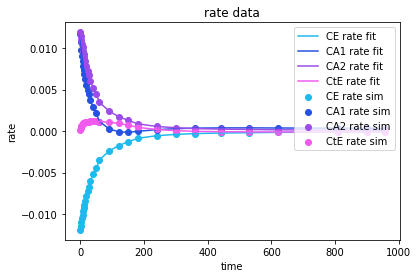

In [74]:
# check rate agreement
plt.scatter(timespan[:-1], rate_lists_1[0], label ='CE rate sim', color = '#1EBAEE')
plt.scatter(timespan[:-1], rate_lists_1[1], label ='CA1 rate sim', color = '#2652E3')
plt.scatter(timespan[:-1], rate_lists_1[2], label ='CA2 rate sim', color = '#9C4CE8')
plt.scatter(timespan[:-1], rate_lists_1[3], label ='CtE rate sim', color = '#F05BEE')
plt.plot(timespan[:-1], changed_rates_1[0], label ='CE rate fit', color = '#1EBAEE')
plt.plot(timespan[:-1], changed_rates_1[1], label ='CA1 rate fit', color = '#2652E3')
plt.plot(timespan[:-1], changed_rates_1[2], label ='CA2 rate fit', color = '#9C4CE8')
plt.plot(timespan[:-1], changed_rates_1[3], label ='CtE rate fit', color = '#F05BEE')
plt.title('rate data')
plt.xlabel('time')
plt.ylabel('rate')
plt.legend()
# plt.savefig("MEP_figures/paper/rate_graph.svg",dpi=300)

In [97]:
#construct kinetic parameters from rate constant guesses
arrhenius_dict = {'T': [323,363,393],'k1': [0.005918,0.01205,0.0181],'k2f': [0.008778,0.01547,0.01905],'k2b': [0.00223,0.004268,0.005717],'k3': [0.0582,0.09091,0.03785],'k4': [0.019765,0.032977,0.044557],'k5': [0.0048423,0.012629,0.014698]}
Eact_list = []
A_list = []
for variable,lis in arrhenius_dict.items():
    log_list = np.log(lis)
    reciprocal_list = 1/np.array(arrhenius_dict['T'])
    lin_model = np.polyfit(reciprocal_list,log_list,1)
    slope = lin_model[0]
    intercept = lin_model[1]
    Eact_list.append(slope*8.314)
    A_list.append(np.exp(intercept))
for i in range(len(A_list)):
    print(Eact_list[i], A_list[i])

-2946.6329121030353 966.5892437488022
-16900.045711344268 3.216698930271982
-11886.141682211477 0.750101914747151
-14350.073809130881 0.4745393588882738
4819.46074270118 0.011552797553905678
-12276.335827015644 1.9153149968730057
-17376.140559653242 3.346718238586


In [100]:
#block to check agreement of guessed and true model
def check_plots(T,P,S0,Ccat0):
    R= 8.314
    D = 8e-2
    A = np.pi/4*D**2
    KlaH2 = 4.5e-2 #this value might be possible in very turbulent media, i don't know the nusselt correlation for stirred tank gas/liquid interfaces
    KH= 1282
    k1 = A_list[1]*np.exp(Eact_list[1]/(R*T))
    k2f = A_list[2]*np.exp(Eact_list[2]/(R*T))
    k2b = A_list[3]*np.exp(Eact_list[3]/(R*T))
    k3 = A_list[4]*np.exp(Eact_list[4]/(R*T))
    k4 = A_list[5]*np.exp(Eact_list[5]/(R*T))
    k5 = A_list[6]*np.exp(Eact_list[6]/(R*T))
    timespan = [0, 1.46, 3.46, 5.46, 7.46, 9.46, 11.46, 13.46, 15.46, 19.46, 23.46, 27.46, 31.46, 40.46, 50.46, 60.46, 90.46, 120.46, 150.46, 180.46, 240.46, 300.46, 360.46, 440.46, 530.46, 620.46, 810.46, 900.46, 955, 1246]
    time = timespan[-1]
    init = [S0,0,0,0,Ccat0,0,0,0]
    def diff(x, init):
        CE, CA1, CA2, CtE,Cprecat, Ccat, Ccatdead, H2uptake = init
        dEdt = -k1*CE*Cprecat - k2f*CE*CA1 + k2b*CtE*CA2
        dA1dt = k1*CE*Cprecat - k2f*CE*CA1 + k2b*CtE*CA2 + 2*k3*CtE*Cprecat
        dA2dt = k1*CE*Cprecat + k2f*CE*CA1 - k2b*CtE*CA2
        dtEdt = k2f*CE*CA1 - k2b*CtE*CA2 - k3*CtE*Cprecat
        dprecatdt = -k1*CE*Cprecat - k3*CtE*Cprecat + k4*Ccat*CH2 - k5*Cprecat
        dcatdt = k1*CE*Cprecat + k3*CtE*Cprecat - k4*Ccat*CH2
        dcatdeaddt = k5*Cprecat
        dH2uptakedt = k4*Ccat*CH2
        return dEdt, dA1dt, dA2dt, dtEdt, dprecatdt, dcatdt,dcatdeaddt, dH2uptakedt
    
    
    sol = integrate.solve_ivp(diff, [0,time], init, t_eval = timespan)
    
    k1 = A1*np.exp(E1/(R*T))
    k2f = A2f*np.exp(E2f/(R*T))
    k2b = A2b*np.exp(E2b/(R*T))
    k3 = A3*np.exp(E3/(R*T))
    k4 = A4*np.exp(E4/(R*T))
    k5 = A5*np.exp(E5/(R*T))
    

    
    sol_true = integrate.solve_ivp(diff, [0,time], init, t_eval = timespan)
    
    plt.figure()
    plt.subplot(1,2,1)
    plt.plot(sol.t,sol.y[0], label = 'CE')
    plt.plot(sol.t,sol.y[1], label = 'CA1')
    plt.plot(sol.t,sol.y[2], label = 'CA2')
    plt.plot(sol.t,sol.y[3], label = 'CtE')
    plt.plot(sol.t,sol.y[4], label = 'Cprecat')
    plt.plot(sol.t,sol.y[5], label = 'Ccat')
    plt.plot(sol.t,sol.y[6], label = 'Cdeadcat')
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(sol_true.t,sol_true.y[0], label = 'CE')
    plt.plot(sol_true.t,sol_true.y[1], label = 'CA1')
    plt.plot(sol_true.t,sol_true.y[2], label = 'CA2')
    plt.plot(sol_true.t,sol_true.y[3], label = 'CtE')
    plt.plot(sol_true.t,sol_true.y[4], label = 'Cprecat')
    plt.plot(sol_true.t,sol_true.y[5], label = 'Ccat')
    plt.plot(sol_true.t,sol_true.y[6], label = 'Cdeadcat')
    plt.title(f'T={T}, P={P}, S0={S0}, Ccat0={Ccat0}')
    plt.legend()
    
    plt.figure()
    plt.plot(sol.t,sol.y[0], label = 'CE',color = '#2DE8A0')
    plt.plot(sol.t,sol.y[1], label = 'CA1', color = '#1EBAEE')
    plt.plot(sol.t,sol.y[2], label = 'CA2', color = '#2652E3')
    plt.plot(sol.t,sol.y[3], label = 'CtE', color = '#9C4CE8')
    plt.plot(sol.t,sol.y[4], label = 'Cactcat', color = '#F05BEE')
    plt.plot(sol.t,sol.y[5], label = 'Ccat',color = '#BF2947')
    plt.plot(sol.t,sol.y[6], label = 'Cdeadcat',color = '#666666')
    plt.legend()
#     plt.savefig(f"MEP_figures/guess_{T}.png",dpi=300)
    
    return (r2_score(sol_true.y[0],sol.y[0])+r2_score(sol_true.y[1],sol.y[1])+r2_score(sol_true.y[2],sol.y[2])+r2_score(sol_true.y[3],sol.y[3])+r2_score(sol_true.y[4],sol.y[4]))/5,(r2_score(sol_true.y[5],sol.y[5])+r2_score(sol_true.y[6],sol.y[6]))/2, r2_score(sol_true.y[7],sol.y[7])

(0.9962848051565256, 0.9828534524361315, 0.9996004529384557)
(0.9998700523884969, 0.9995472775175771, 0.9999963754892462)
(0.9957965026441041, 0.9836737846622594, 0.9995510173847693)
(0.9666460798213203, 0.9162336310636945, 0.9932413910763516)


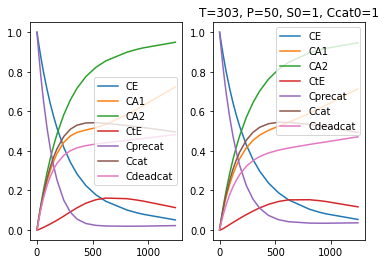

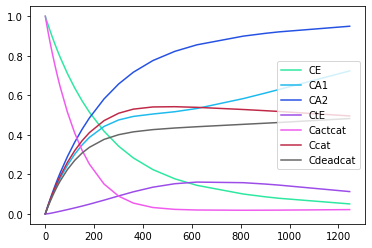

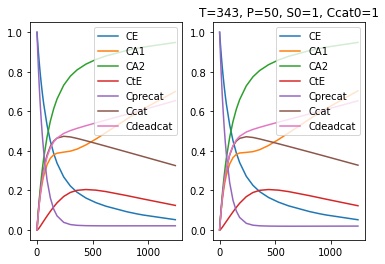

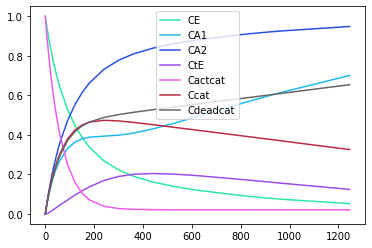

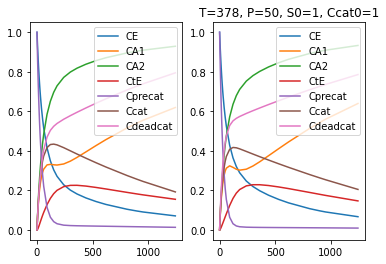

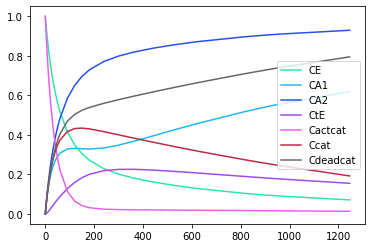

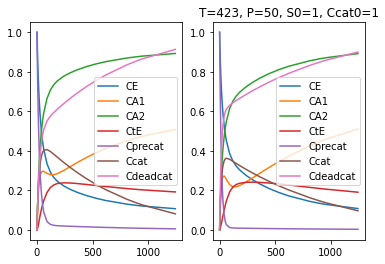

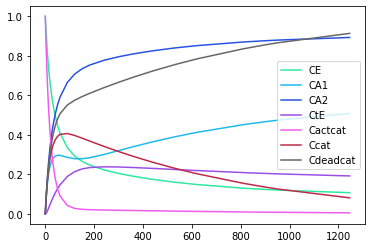

In [101]:
#plots for the report
print(check_plots(303,50,1,1))
print(check_plots(343,50,1,1))
print(check_plots(378,50,1,1))
print(check_plots(423,50,1,1))

(-2.003802492175738, 0.09130442665728711, 0.9178570087809934)
(-0.1571593016766386, 0.14081935860352568, 0.9558322721833095)
(0.2850220909775078, 0.2432256225588052, 0.9501506697989256)
(0.5125712361420839, 0.3304369501403029, 0.9323722912502137)
(0.6158286056913921, 0.32667206415595756, 0.9070957368042357)
(0.6375031970017064, 0.2664249328536107, 0.8866280262408938)
(0.6264564801886591, 0.18577327864184817, 0.8674270163631154)
(0.5467734373297634, 0.08989673889310523, 0.8391324523088631)
(0.4351406210586045, 0.17432433965769872, 0.8296605225094089)
(0.330773929942319, 0.3707571166217819, 0.8395907155072025)


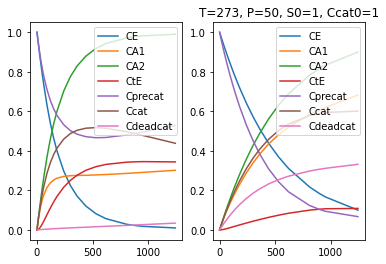

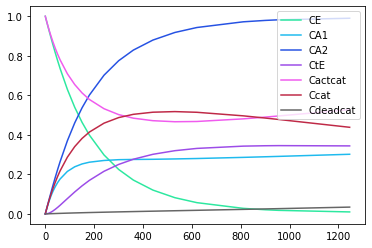

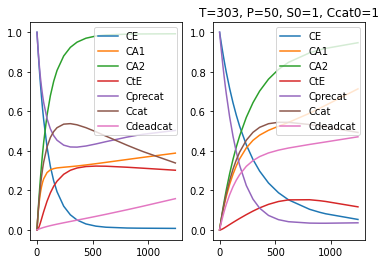

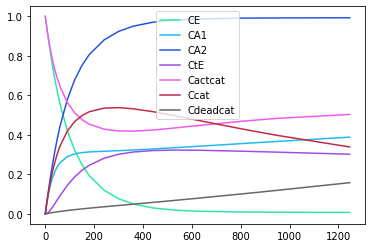

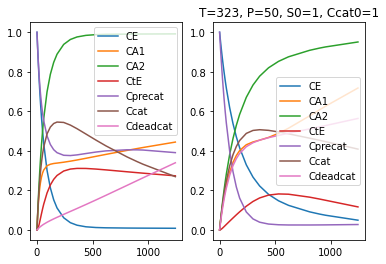

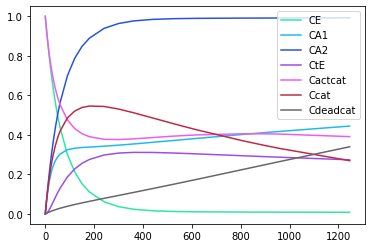

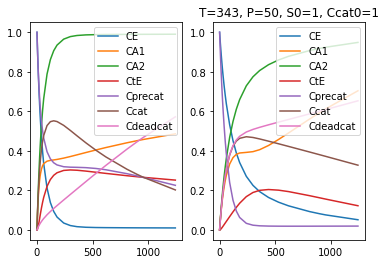

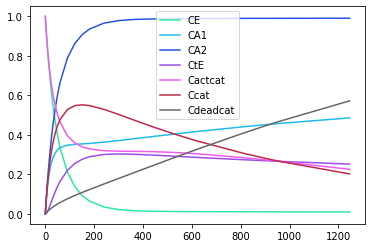

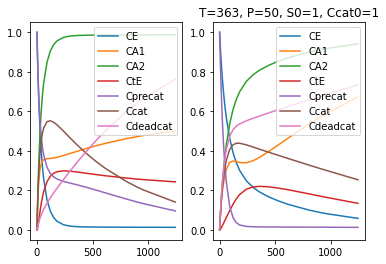

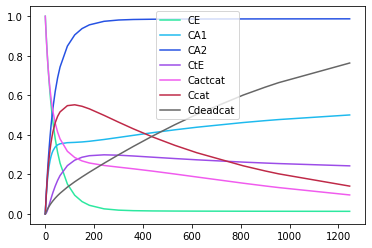

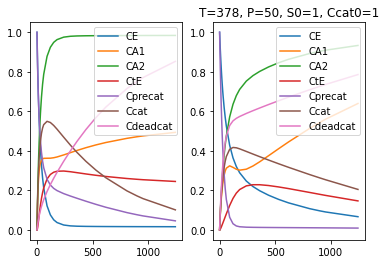

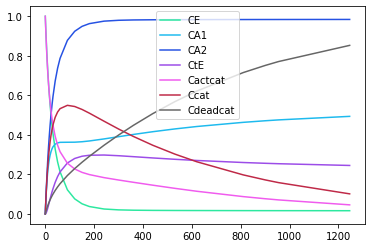

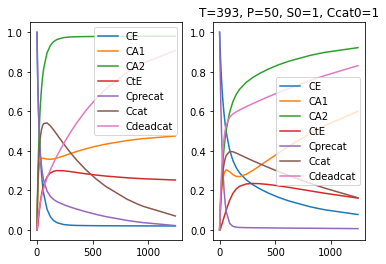

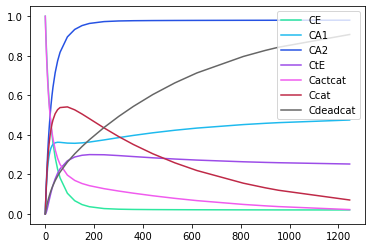

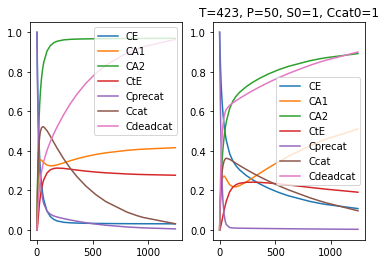

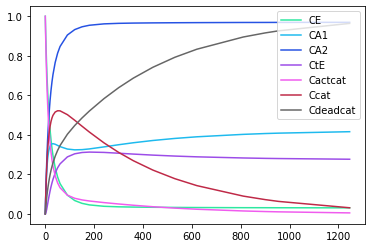

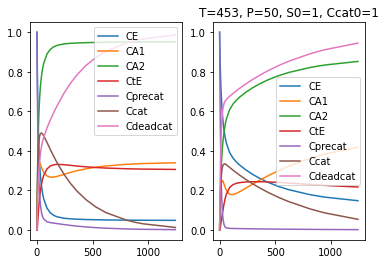

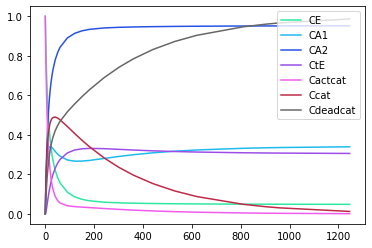

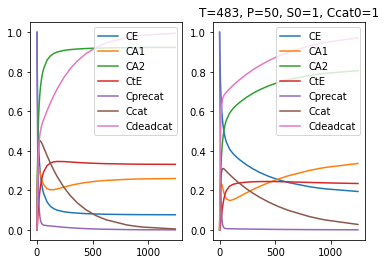

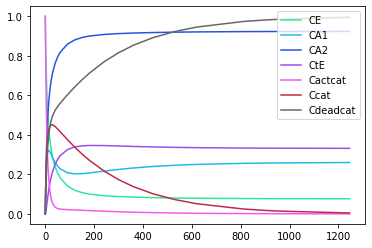

In [48]:
#agreement for temperature ranges
print(check_plots(273,50,1,1))
print(check_plots(303,50,1,1))
print(check_plots(323,50,1,1))
print(check_plots(343,50,1,1))
print(check_plots(363,50,1,1))
print(check_plots(378,50,1,1))
print(check_plots(393,50,1,1))
print(check_plots(423,50,1,1))
print(check_plots(453,50,1,1))
print(check_plots(483,50,1,1))

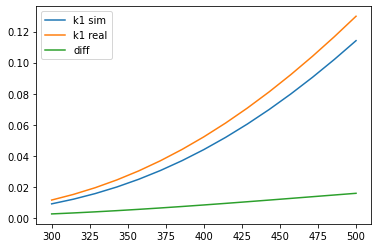

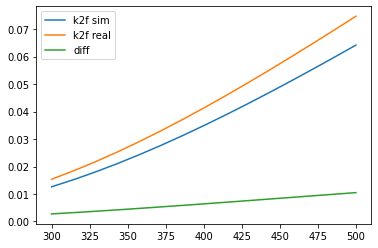

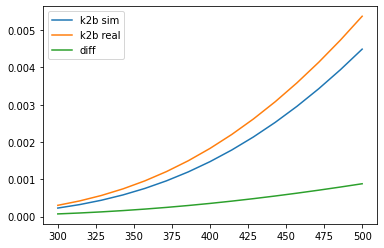

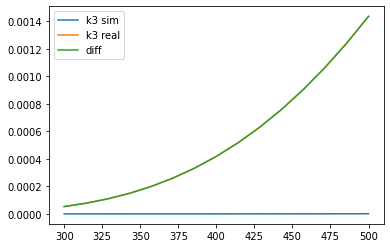

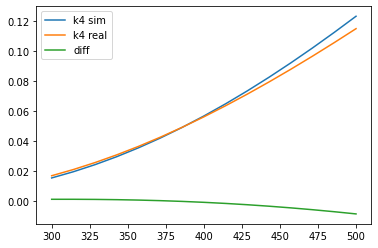

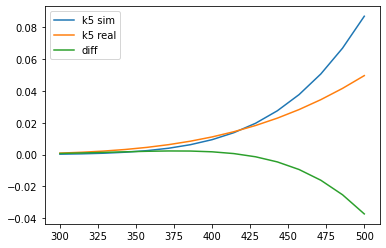

In [30]:
#plots to visualize the deviance over as a function of temperature
temp_arr = np.linspace(300,500,15)
R= 8.314
const_lists_sim = [[],[],[],[],[],[],[]]
const_lists_real = [[],[],[],[],[],[],[]]
diff_lists = [[],[],[],[],[],[],[]]
for T in temp_arr:
    k1 = A_list[1]*np.exp(Eact_list[1]/(R*T))
    k2f = A_list[2]*np.exp(Eact_list[2]/(R*T))
    k2b = A_list[3]*np.exp(Eact_list[3]/(R*T))
    k3 = A_list[4]*np.exp(Eact_list[4]/(R*T))
    k4 = A_list[5]*np.exp(Eact_list[5]/(R*T))
    k5 = A_list[6]*np.exp(Eact_list[6]/(R*T))
    const_lists_sim[0].append(k1)
    const_lists_sim[1].append(k2f)
    const_lists_sim[2].append(k2b)
    const_lists_sim[3].append(k3)
    const_lists_sim[4].append(k4)
    const_lists_sim[5].append(k5)
    
for T in temp_arr:
    k1 = A1*np.exp(E1/(R*T))
    k2f = A2f*np.exp(E2f/(R*T))
    k2b = A2b*np.exp(E2b/(R*T))
    k3 = A3*np.exp(E3/(R*T))
    k4 = A4*np.exp(E4/(R*T))
    k5 = A5*np.exp(E5/(R*T))
    const_lists_real[0].append(k1)
    const_lists_real[1].append(k2f)
    const_lists_real[2].append(k2b)
    const_lists_real[3].append(k3)
    const_lists_real[4].append(k4)
    const_lists_real[5].append(k5)

for i in range(len(const_lists_sim[0])):
    diff_lists[0].append(const_lists_real[0][i]-const_lists_sim[0][i])
    diff_lists[1].append(const_lists_real[1][i]-const_lists_sim[1][i])
    diff_lists[2].append(const_lists_real[2][i]-const_lists_sim[2][i])
    diff_lists[3].append(const_lists_real[3][i]-const_lists_sim[3][i])
    diff_lists[4].append(const_lists_real[4][i]-const_lists_sim[4][i])
    diff_lists[5].append(const_lists_real[5][i]-const_lists_sim[5][i])
    
plt.figure()
plt.plot(temp_arr,const_lists_sim[0], label = 'k1 sim')
plt.plot(temp_arr,const_lists_real[0], label = 'k1 real')
plt.plot(temp_arr,diff_lists[0], label = 'diff')
plt.legend()
plt.figure()
plt.plot(temp_arr,const_lists_sim[1], label = 'k2f sim')
plt.plot(temp_arr,const_lists_real[1], label = 'k2f real')
plt.plot(temp_arr,diff_lists[1], label = 'diff')
plt.legend()
plt.figure()
plt.plot(temp_arr,const_lists_sim[2], label = 'k2b sim')
plt.plot(temp_arr,const_lists_real[2], label = 'k2b real')
plt.plot(temp_arr,diff_lists[2], label = 'diff')
plt.legend()
plt.figure()
plt.plot(temp_arr,const_lists_sim[3], label = 'k3 sim')
plt.plot(temp_arr,const_lists_real[3], label = 'k3 real')
plt.plot(temp_arr,diff_lists[3], label = 'diff')
plt.legend()
plt.figure()
plt.plot(temp_arr,const_lists_sim[4], label = 'k4 sim')
plt.plot(temp_arr,const_lists_real[4], label = 'k4 real')
plt.plot(temp_arr,diff_lists[4], label = 'diff')
plt.legend()
plt.figure()
plt.plot(temp_arr,const_lists_sim[5], label = 'k5 sim')
plt.plot(temp_arr,const_lists_real[5], label = 'k5 real')
plt.plot(temp_arr,diff_lists[5], label = 'diff')
plt.legend()
    


(0.9807219484971735, 0.9589825063877111, 0.9997978984944857)
(0.9832033412077104, 0.9547754047288727, 0.9998787617468751)
(0.9875837766153115, 0.8902673153633522, 0.9999161763143225)
(0.9746302975102703, 0.9600965962891, 0.9994140599660829)
(0.9784019229036771, 0.9639363566472703, 0.9995442319049282)
(0.9882894577811797, 0.9560500526386437, 0.9998684938153701)
(0.9541699865565452, 0.960067253149731, 0.9991672325108802)
(0.9611653021869575, 0.9630882872020659, 0.9989186830195032)
(0.9735517655772428, 0.969745921411496, 0.99907900295857)


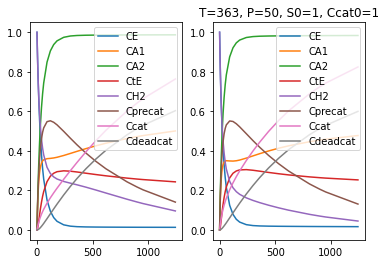

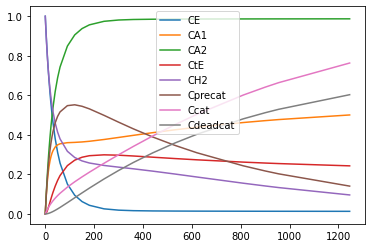

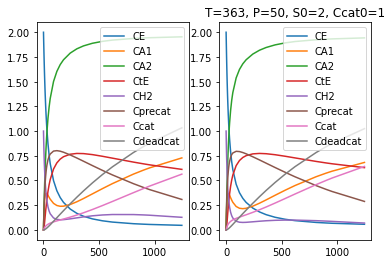

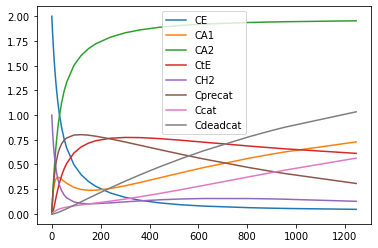

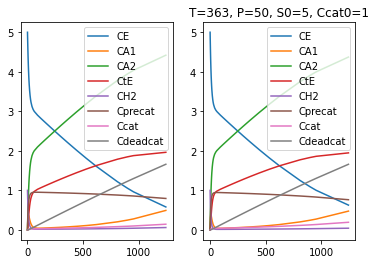

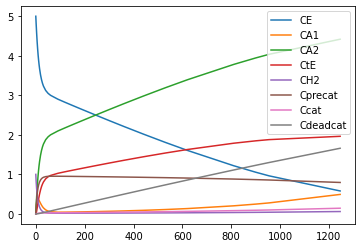

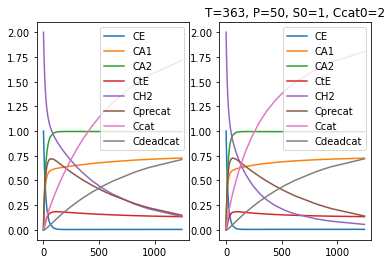

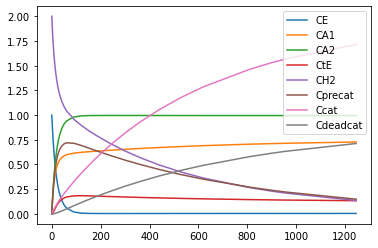

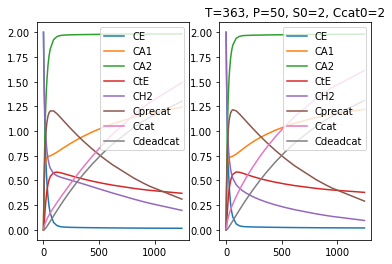

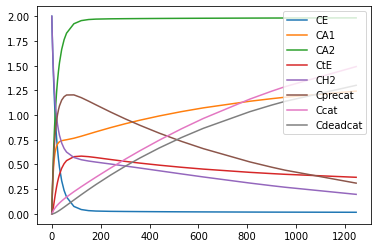

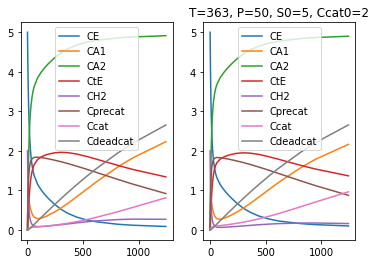

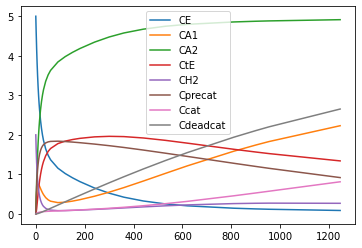

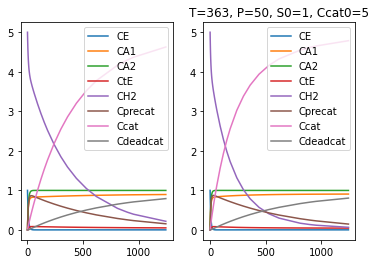

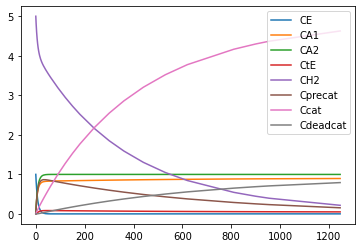

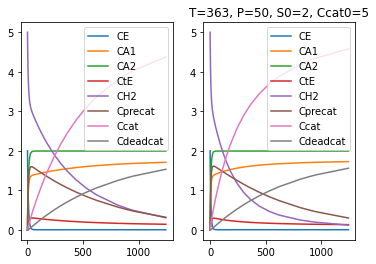

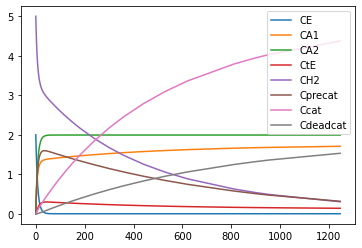

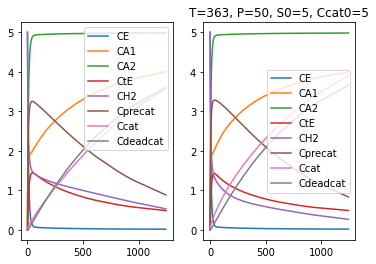

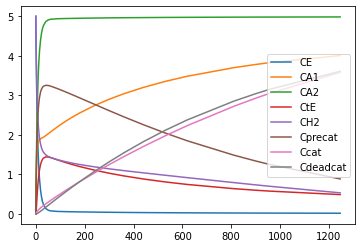

In [31]:
#plots for different initial conditions
print(check_plots(363,50,1,1))
print(check_plots(363,50,2,1))
print(check_plots(363,50,5,1))
print(check_plots(363,50,1,2))
print(check_plots(363,50,2,2))
print(check_plots(363,50,5,2))
print(check_plots(363,50,1,5))
print(check_plots(363,50,2,5))
print(check_plots(363,50,5,5))

In [32]:
#function that runs the guesses of the reaction condition optimization algorithm
def get_experiment(T,P,S0,Ccat0):
    R= 8.314
    KH= 1282
    CH2 = P/KH
    k1 = 5.207*np.exp(-15879/(R*T))
    k2f = 0.7366*np.exp(-10143/(R*T))
    k2b = 0.3866*np.exp(-18522/(R*T))
    k3 = 0.000214*np.exp(-21411/(R*T))
    k4 = 2.72*np.exp(-12860/(R*T))
    k5 = 649*np.exp(-37073/(R*T))
    init = [S0,0,0,0,Ccat0,0,0,0]
    def diff(x, init):
        CE, CA1, CA2, CtE,Cprecat, Ccat, Ccatdead, H2uptake = init
        dEdt = -k1*CE*Cprecat - k2f*CE*CA1 + k2b*CtE*CA2
        dA1dt = k1*CE*Cprecat - k2f*CE*CA1 + k2b*CtE*CA2 + 2*k3*CtE*Cprecat
        dA2dt = k1*CE*Cprecat + k2f*CE*CA1 - k2b*CtE*CA2
        dtEdt = k2f*CE*CA1 - k2b*CtE*CA2 - k3*CtE*Cprecat
        dprecatdt = -k1*CE*Cprecat - k3*CtE*Cprecat + k4*Ccat*CH2 - k5*Cprecat
        dcatdt = k1*CE*Cprecat + k3*CtE*Cprecat - k4*Ccat*CH2
        dcatdeaddt = k5*Cprecat
        dH2uptakedt = k4*Ccat*CH2
        return dEdt, dA1dt, dA2dt, dtEdt, dprecatdt, dcatdt,dcatdeaddt, dH2uptakedt

    sol = integrate.solve_ivp(diff, [0,time_1], init, t_eval = timespan)
    
#     plt.plot(sol.t,sol.y[0], label = 'CE')
#     plt.plot(sol.t,sol.y[1], label = 'CA1')
#     plt.plot(sol.t,sol.y[2], label = 'CA2')
#     plt.plot(sol.t,sol.y[3], label = 'CtE')
#     plt.plot(sol.t,sol.y[4], label = 'Cprecat')
#     plt.plot(sol.t,sol.y[5], label = 'Ccat')
#     plt.plot(sol.t,sol.y[6], label = 'Cdeadcat')
#     plt.legend()

    return (np.average(sol.y[1]) + np.average(sol.y[2]))/(S0*Ccat0)
    

In [33]:
#characteristics of the optimizer algorithm
pbounds = {'T': (273,453), 'P': (40,50), 'S0': (1,10), 'Ccat0' :(0.1,1)}

optimizer = BayesianOptimization(
    f=get_experiment,
    pbounds=pbounds,
)

In [34]:
#finfind the optima
optimizer.maximize(
    init_points=10,
    n_iter=100,
    kappa = 1.5,
)

|   iter    |  target   |   Ccat0   |     P     |    S0     |     T     |
-------------------------------------------------------------------------
|  1        |  0.3946   |  0.6815   |  40.74    |  6.487    |  406.4    |
|  2        |  0.3052   |  0.8236   |  46.91    |  8.373    |  382.2    |
|  3        |  0.3174   |  0.1721   |  49.55    |  9.292    |  417.4    |
|  4        |  0.8343   |  0.4138   |  45.85    |  1.242    |  293.3    |
|  5        |  0.4138   |  0.5935   |  46.64    |  6.941    |  433.6    |
|  6        |  0.604    |  0.1892   |  40.33    |  4.071    |  411.8    |
|  7        |  0.8019   |  0.2252   |  48.66    |  3.207    |  443.2    |
|  8        |  0.252    |  0.728    |  43.36    |  8.559    |  339.3    |
|  9        |  0.3954   |  0.8323   |  40.27    |  6.53     |  413.9    |
|  10       |  0.1766   |  0.2938   |  42.13    |  8.836    |  273.5    |
|  11       |  0.4611   |  0.3398   |  49.56    |  5.947    |  409.2    |
|  12       |  0.7112   |  0.4093   | 

|  68       |  1.578    |  0.1      |  47.72    |  1.0      |  362.0    |
|  69       |  1.275    |  0.4679   |  49.04    |  1.008    |  359.8    |
|  70       |  1.098    |  0.4228   |  47.52    |  1.488    |  362.0    |
|  71       |  1.578    |  0.1      |  48.16    |  1.0      |  361.3    |
|  72       |  1.566    |  0.1      |  47.48    |  1.0      |  360.0    |
|  73       |  1.558    |  0.1      |  46.22    |  1.0      |  360.2    |
|  74       |  1.564    |  0.1      |  46.89    |  1.0      |  360.6    |
|  75       |  1.19     |  0.2495   |  45.22    |  1.387    |  357.9    |
|  76       |  0.9491   |  0.946    |  42.87    |  1.027    |  359.7    |
|  77       |  1.105    |  0.3911   |  47.12    |  1.476    |  358.8    |
|  78       |  1.157    |  0.5825   |  44.79    |  1.07     |  361.6    |
|  79       |  1.428    |  0.2279   |  48.28    |  1.092    |  362.9    |
|  80       |  1.459    |  0.2293   |  46.55    |  1.019    |  359.3    |
|  81       |  1.369    |  0.3651   | 